# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Convolutional Autoencoder

</font>
</div>

# Theoretical recall: what is a convolutional autoencoder?

<div class="alert alert-info">
<font color=black>

- Autoencoder are a variation of ANNs.
- They are succefuly applied to image reconstruction.
- **Why image reconstruction?** This helps in obtaining the noise-free image.
- **Convolutional Autoencoders** are general-purpose feature extractors differently from general autoencoders that completely ignore the 2D image structure

</font>
</div>

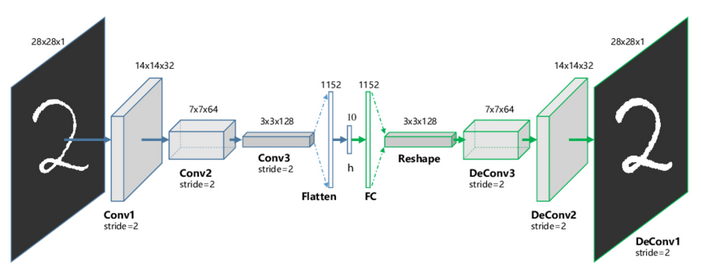

# Import modules

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

# Import the dataset

In [6]:
#Converting data to torch.FloatTensor
transform = transforms.ToTensor()

# Download the training and test datasets
train_data = datasets.CIFAR10(root = '../DATASETS/CIFAR10', train=True, download=True, transform=transform)

test_data = datasets.CIFAR10(root = '../DATASETS/CIFAR10', train=False, download=True, transform=transform)

0it [00:00, ?it/s]

Extracting ../DATASETS/CIFAR10/cifar-10-python.tar.gz to ../DATASETS/CIFAR10
Files already downloaded and verified


In [7]:
#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0)

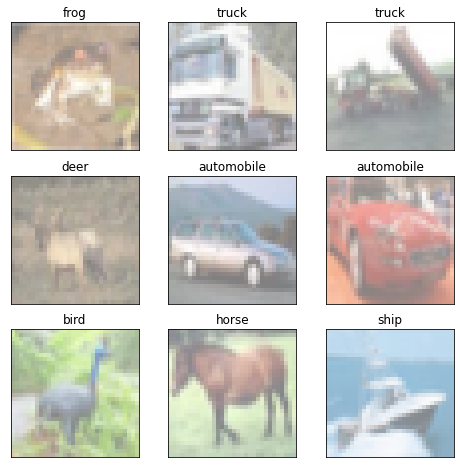

In [8]:
# We will print some random images from the training data set.
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Convolutional Autoencoder

In [9]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x

In [10]:
#Instantiate the model
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [11]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)


cpu


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
#Epochs
n_epochs = 10

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

# Post-processing

<div class="alert alert-info">
<font color=black>

- So, as we can see above, the convolutional autoencoder has generated the reconstructed images corresponding to the input images. 
- The training of the model can be performed for more epochs to generate a better imagine reconstruction.

</font>
</div>

Original Images


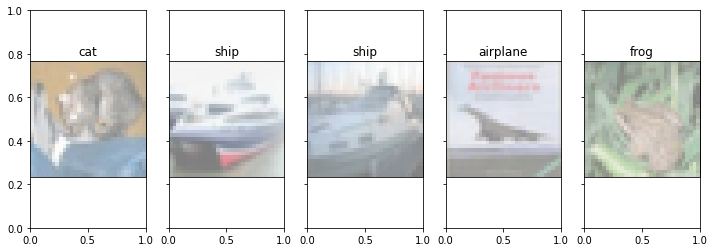

Reconstructed Images


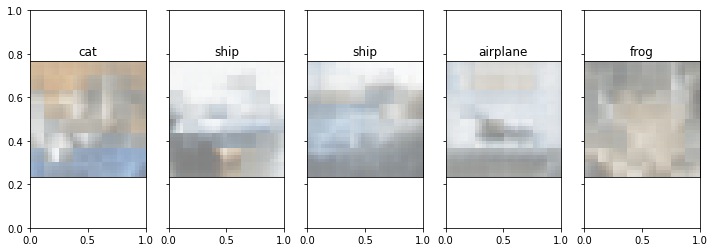

In [16]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
output = model(images)
images = images.numpy()

batch_size = 32
output = output.view(batch_size, 3, 32, 32)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 


# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

</font>
</div>